In [1]:
pip install pandas matplotlib tensorflow

In [2]:
import pandas as pd
df = pd.read_csv("/content/Tweets.csv")

In [3]:
review_df = df[['text','airline_sentiment']]

print(review_df.shape)
review_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
review_df = review_df[review_df['airline_sentiment'] != 'neutral']

print(review_df.shape)
review_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [6]:
review_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [8]:
tweet = review_df.text.values

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(tweet)

In [10]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [15]:
vocab_size =   25768
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           824576    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 841,227
Trainable params: 841,227
Non-trainable params: 0
________________________________________________

In [16]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 114s 377ms/step - loss: 0.4019 - accuracy: 0.8328 - val_loss: 0.2098 - val_accuracy: 0.9207
Epoch 2/5
289/289 [==============================] - 101s 349ms/step - loss: 0.2242 - accuracy: 0.9146 - val_loss: 0.1661 - val_accuracy: 0.9394
Epoch 3/5
289/289 [==============================] - 98s 339ms/step - loss: 0.1659 - accuracy: 0.9386 - val_loss: 0.1587 - val_accuracy: 0.9441
Epoch 4/5
289/289 [==============================] - 98s 339ms/step - loss: 0.1290 - accuracy: 0.9504 - val_loss: 0.1954 - val_accuracy: 0.9394
Epoch 5/5
289/289 [==============================] - 99s 344ms/step - loss: 0.1135 - accuracy: 0.9596 - val_loss: 0.1760 - val_accuracy: 0.9467


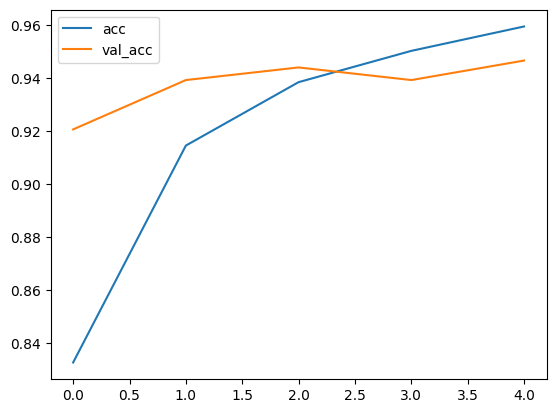

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

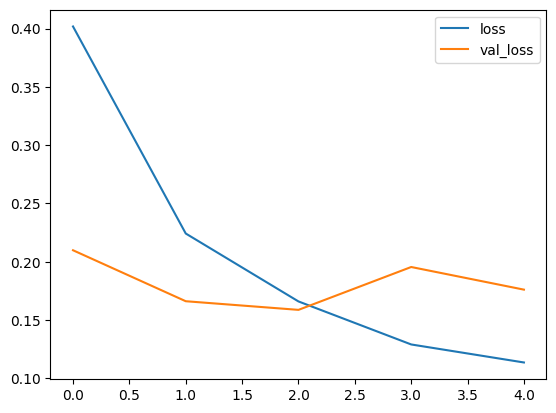

<Figure size 640x480 with 0 Axes>

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

In [19]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "I enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 322ms/step
Predicted label:  positive
1/1 [==============================] - 0s 45ms/step
Predicted label:  negative
